# Tracer Transport Operators

To model marine biogeochemical processes on a global scale we need to be able to account for the movement of chemical constituents both horizontally and vertically.
We do this with a **tracer transport operator**.
When this operator acts on a tracer field it produces the advective-diffusive divergence of the tracer.

## Discretization

In order to represent the transport operator on a computer one needs to discretize the tracer concentration field and the operator.
Once discretized the tracer field is represented as a vector and the operator is represented as a sparse matrix.

> **Note**
> A sparse matrix behaves the same way as a regular matrix.
> The only difference is that in a sparse matrix the majority of the entries are zeros.
> These zeros are not stored explicitly to save computer memory making it possible to deal with fairly high resolution ocean models.

Mathematically, the discretization converts an expression with partial derivatives into a matrix vector product.
For the ocean circulation, we do the following conversion

$$\nabla \cdot \left[ \boldsymbol{u} - \mathbf{K} \cdot \nabla \right] C \longrightarrow \mathbf{T} \, \boldsymbol{C}$$

where $C(\boldsymbol{r})$ is a tracer concentration at location $\boldsymbol{r}$.
(We often omit the $\boldsymbol{r}$ dependency in equations for brevity.)
The $\nabla \cdot \left[ \boldsymbol{u} - \mathbf{K} \cdot \nabla \right] C$ term is the flux divergence of the tracer due to the marine currents and turbulent eddies.
($\boldsymbol{u}$ is the 3D current velocity and $\mathbf{K}$ the diffusivity matrix.)
The matrix $\mathbf{T}$ is the flux divergence transport matrix and $\boldsymbol{C}$ is the tracer concentration vector.

One can go a long way towards understanding what a tracer transport operator is by playing with a simple model with only a few boxes, which is the goal of this example.

The simple box model we consider is embeded in a 2×2×2 "shoebox".
It has 5 *wet* boxes and 3 *dry* boxes, as illustrated below:

<img src="https://user-images.githubusercontent.com/4486578/58314610-3b130b80-7e53-11e9-9fe8-9527cdcca2d0.png" width =800>

The circulation consists of
- a meridional overturning circulation flowing in a cycle through boxes 1 → 2 → 6 → 5 → 1 (shown in the "meridional section 1" panel above)
- a zonal current in a reentrant cycling through boxes 1 → 3 → 1 (shown in the "layer 1" panel above)
- vertical mixing representing deep convection between boxes 2 ↔ 6 (not shown)

## The model grid and the transport matrix

Like for any models using AIBECS, we start by telling Julia just that:

In [1]:
using AIBECS

We then load the shoebox model via

In [2]:
grd, T = Primeau_2x2x2.load() ;

Creating François Primeau's 2x2x2 model ✔


where we have loaded 2 objects, `grd` and `T`.

`grd` is an `OceanGrid` object, of size 2×2×2:

In [3]:
grd

This object is defined in the [OceanGrids](https://github.com/briochemc/OceanGrids.jl) package, on which AIBECS depends.
There are many ways to look inside the grid, one of which is to iterate over it:

In [4]:
[println(box) for box in grd] ;

Wet OceanGridBox at CartesianIndex(1, 1, 1):
  location: -45.0°N, 90.0°E
  depth: 100.0 m
  size: 80060.3 km × 1592.8 km × 200.0 m (δx × δy × δz)

Wet OceanGridBox at CartesianIndex(2, 1, 1):
  location: 45.0°N, 90.0°E
  depth: 100.0 m
  size: 80060.3 km × 1592.8 km × 200.0 m (δx × δy × δz)

Wet OceanGridBox at CartesianIndex(1, 2, 1):
  location: -45.0°N, 270.0°E
  depth: 100.0 m
  size: 80060.3 km × 1592.8 km × 200.0 m (δx × δy × δz)

Dry OceanGridBox at CartesianIndex(2, 2, 1):
  location: 45.0°N, 270.0°E
  depth: 100.0 m
  size: 80060.3 km × 1592.8 km × 200.0 m (δx × δy × δz)

Wet OceanGridBox at CartesianIndex(1, 1, 2):
  location: -45.0°N, 90.0°E
  depth: 1950.0 m
  size: 80060.3 km × 1592.8 km × 3500.0 m (δx × δy × δz)

Wet OceanGridBox at CartesianIndex(2, 1, 2):
  location: 45.0°N, 90.0°E
  depth: 1950.0 m
  size: 80060.3 km × 1592.8 km × 3500.0 m (δx × δy × δz)

Dry OceanGridBox at CartesianIndex(1, 2, 2):
  location: -45.0°N, 270.0°E
  depth: 1950.0 m
  size: 80060.3 km × 15

shows some details about all the boxes of the model, one at a time.
The `grd` object also contains other information about the grid, like the 3D depths of the boxes:

In [5]:
grd.depth_3D

2×2×2 Array{Quantity{Float64,𝐋,Unitful.FreeUnits{(m,),𝐋,nothing}},3}:
[:, :, 1] =
 100.0 m  100.0 m
 100.0 m  100.0 m

[:, :, 2] =
 1950.0 m  1950.0 m
 1950.0 m  1950.0 m

or the 3D latitudes:

In [6]:
grd.lat_3D

2×2×2 Array{Quantity{Float64,NoDims,Unitful.FreeUnits{(°,),NoDims,nothing}},3}:
[:, :, 1] =
 -45.0°  -45.0°
  45.0°   45.0°

[:, :, 2] =
 -45.0°  -45.0°
  45.0°   45.0°

where you can check that northwards = downwards in the array.
You may notice these come with units!
This helps ensure that degrees of latitude are not confused with meters for example.

> **Note**
> Julia comes with [Unitful](https://github.com/PainterQubits/Unitful.jl), a package for using units, which AIBECS uses.

Inside of `grd`, there is information of which boxes of the grid are "wet" (or "dry").
`wet3D` is a 3D array representing the 3D ocean with `true` for "wet" boxes and `false` for "dry" boxes.
Let's have a look at its contents:

In [7]:
wet3D = grd.wet3D

2×2×2 BitArray{3}:
[:, :, 1] =
 true   true
 true  false

[:, :, 2] =
 true  false
 true  false

It's a 2×2×2 `BitArray`, i.e., an array of bit elements (the `true` and `false` entries).
You can check that it matches our "shoebox" model.
(Well, except for the orientation, for which northwards in the box model is downwards in the array.)

We can find all the wet boxes simply via

In [8]:
findall(wet3D)

5-element Array{CartesianIndex{3},1}:
 CartesianIndex(1, 1, 1)
 CartesianIndex(2, 1, 1)
 CartesianIndex(1, 2, 1)
 CartesianIndex(1, 1, 2)
 CartesianIndex(2, 1, 2)

These are the 3D indices of the wet boxes, `(i,j,k)`, called the "cartesian" indices.
If you want the "linear" indices, i.e., the numbers as shown in the image of the shoebox model, you can simply transform `wet3D` into a vector, via

In [9]:
iwet = findall(vec(wet3D))

5-element Array{Int64,1}:
 1
 2
 3
 5
 6

We can also check that we indeed have the expected number of wet boxes via

In [10]:
nb = length(iwet)

5

Now let's have a look at the transport matrix `T`, which represents $\nabla \cdot \left[ \boldsymbol{u} - \mathbf{K} \cdot \nabla \right]$, i.e., the flux divergence operator for dissolved tracers:

In [11]:
T

5×5 SparseMatrixCSC{Float64,Int64} with 12 stored entries:
  [1, 1]  =  4.50923e-9
  [2, 1]  =  -5.88161e-10
  [3, 1]  =  -3.92107e-9
  [2, 2]  =  9.80268e-10
  [5, 2]  =  -5.60153e-11
  [1, 3]  =  -3.92107e-9
  [3, 3]  =  3.92107e-9
  [1, 4]  =  -5.88161e-10
  [4, 4]  =  3.36092e-11
  [2, 5]  =  -3.92107e-10
  [4, 5]  =  -3.36092e-11
  [5, 5]  =  5.60153e-11

It's a sparse matrix (a `SparseMatrixCSC` object in Julia), which only stores those entries that are not zero.
We can display the full matrix via

In [12]:
Matrix(T)

5×5 Array{Float64,2}:
  4.50923e-9    0.0          -3.92107e-9  -5.88161e-10   0.0        
 -5.88161e-10   9.80268e-10   0.0          0.0          -3.92107e-10
 -3.92107e-9    0.0           3.92107e-9   0.0           0.0        
  0.0           0.0           0.0          3.36092e-11  -3.36092e-11
  0.0          -5.60153e-11   0.0          0.0           5.60153e-11

to check its structure out.
Note that all the diagonal terms are positive, which is the sign that the transport matrix acts as a divergence, which would be positive for a box containing all the tracer.
For example, if there was only some tracer in box 2, then that tracer should "diverge" away from that box, resulting in the positiva value in that box:

In [13]:
j = 2                            # index where we put some tracer
x = 1.0 * [i == j for i in 1:nb] # vector of 0's except for index j
x, (T * x)[j]

([0.0, 1.0, 0.0, 0.0, 0.0], 9.802682357543846e-10)

shows that the flux divergence `T * x` is positive where we injected the tracer.

## Radiocarbon

Radiocarbon, ¹⁴C, is produced by cosmic rays in the lower stratosphere and upper troposphere.
It quickly reacts with oxygen to produce ¹⁴CO₂, which is then mixed throughout the troposphere and enters the ocean through air–sea gas exchange.
Because the halflife of radiocarbon is only 5730 years a significant amount of decay can occur before the dissolved inorganic radiocarbon (DI¹⁴C) can mix uniformally throughout the ocean.
As such the ¹⁴C serves as a tracer label for water that was recently in contact with the atmosphere.

### Tracer Equation

Mathematically, the ¹⁴C tracer concentration, denoted $R$ (for Radiocarbon), satisfies the following tracer equation:

$$\frac{\partial R}{\partial t} + \nabla \cdot \left[ \boldsymbol{u} - \mathbf{K} \cdot \nabla \right] R = \Lambda(R_\mathsf{atm} - R) - R / \tau,$$

where $\Lambda(R_\mathsf{atm} - R)$ represents the air–sea exchanges and $R / \tau$ the radioactive decay rate.
($\tau$ is the radioactive decay timescale.)

The discretized tracer is thus given by

$$\frac{\partial \boldsymbol{R}}{\partial t} + \mathbf{T} \, \boldsymbol{R} = \mathbf{\Lambda}(R_\mathsf{atm} - \boldsymbol{R}) - \boldsymbol{R} / \tau.$$

### Translation to AIBECS Code

We will perform an idealized radiocarbon simulation in our model and use the ocean circulation defined earlier using AIBECS.
In this model we prescribe the atmospheric concentration, $R_\mathsf{atm}$, to be simply equal to 1.
(We do not specify its unit or its specific value because it is not important for determining the age of a water parcel — only the decay rate does.)

To use AIBECS, one must put the equations into the generic form of

$$\frac{\partial \boldsymbol{x}}{\partial t} + \mathbf{T}(\boldsymbol{p}) \, \boldsymbol{x} = \boldsymbol{G}(\boldsymbol{x}, \boldsymbol{p}),$$

where $\boldsymbol{x}$ is the state vector, $\boldsymbol{p}$ is the vector of model parameters, $\mathbf{T}(\boldsymbol{p})$ is the transport operator, and $\boldsymbol{G}(\boldsymbol{x}, \boldsymbol{p})$ is the local sources minus sinks.

In our radiocarbon-model context, with $\boldsymbol{x} = \boldsymbol{R}$, we have that

$$\boldsymbol{G}(\boldsymbol{x}, \boldsymbol{p}) = \mathbf{\Lambda}(R_\mathsf{atm} - \boldsymbol{x}) - \boldsymbol{x} / \tau.$$

Hence, we must create `T(p)` and `G(x,p)` to give AIBECS the means to simulate the tracer distribution and/or its evolution in time.

#### Sources and Sinks

The local sources and sinks are thus simply given by

In [14]:
function G(x, p)
    τ, Ratm = p.τ, p.Ratm
    return Λ(Ratm .- x, p) - x / τ
end

G (generic function with 1 method)

where `τ` is the decay rate timescale and `Ratm` is the atmospheric concentration of radiocarbon.

We must define the air–sea exchange rate, `Λ(x,p)`, which requires us to define which boxes are located at the surface first.
This is done, e.g., via

In [15]:
surface_boxes = grd.depth_3D[iwet] .== grd.depth[1]

5-element BitArray{1}:
  true
  true
  true
 false
 false

The air–sea exchange rate is then given by

In [16]:
function Λ(x, p)
    λ, h = p.λ, p.h
    return λ / h * surface_boxes .* x
end

Λ (generic function with 1 method)

where `λ` is the piston velocity and `h` is the height of the top layer of the model grid.

#### Parameters

For the air–sea gas exchange, we use a constant piston velocity $\lambda$ of 50m / 10years, which will happen in the top layer, of height given by, well, the height of the top layer.
And for the radioactive decay we use a timescale $\tau$ of 5730/log(2) years.
We define these as parameters using the dedicated API from the AIBECS:

In [17]:
t = empty_parameter_table()                   # initialize an empty table of parameters
add_parameter!(t, :τ, 5730u"yr"/log(2)) # radioactive decay e-folding timescale
add_parameter!(t, :λ, 50u"m" / 10u"yr") # piston velocity
add_parameter!(t, :h, grd.δdepth[1])    # height of top layer
add_parameter!(t, :Ratm, 1.0u"mol/m^3") # atmospheric concentration
t

,symbol,value,unit,printunit,mean_obs,variance_obs,optimizable,description
,Symbol,Float64,Unitful…,Unitful…,Float64,Float64,Bool,String
1,τ,2.60875e11,s,yr,NaN,NaN,false,
2,λ,1.5844e-7,m s^-1,m yr^-1,NaN,NaN,false,
3,h,200.0,m,m,NaN,NaN,false,
4,Ratm,1.0,mol m^-3,mol m^-3,NaN,NaN,false,


shows the parameters that you just created.

We now generate a new object to contain all these parameters via

In [18]:
initialize_Parameters_type(t, "C14_shoebox_parameters") # creates the type for parameters
p = C14_shoebox_parameters()                            # creates the parameters object

     τ = 8.27e+03 [yr] (fixed)
     λ = 5.00e+00 [m yr⁻¹] (fixed)
     h = 2.00e+02 [m] (fixed)
  Ratm = 1.00e+00 [mol m⁻³] (fixed)


#### Generate the state function and its Jacobian

The last step for the setup is for AIBECS to create $\boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p}) = \boldsymbol{G}(\boldsymbol{x}, \boldsymbol{p}) - \mathbf{T}(\boldsymbol{p}) \, \boldsymbol{x}$, which defines the rate of change of the state, $\boldsymbol{x}$.
This is done via

In [19]:
F, ∇ₓF = state_function_and_Jacobian(p -> T, G) # generates the state function (and its Jacobian!)
x = zeros(nb)
F(x,p)

5-element Array{Float64,1}:
 7.922021953507237e-10
 7.922021953507237e-10
 7.922021953507237e-10
 0.0                  
 0.0                  

Note here that AIBECS has automatically created `∇ₓF`, i.e., $\nabla_{\boldsymbol{x}}\boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p})$, which is the Jacobian of the system.
This Jacobian will be useful in the simulations below.

That's it!
Your model is entirely setup and ready to be used for simulations!

## Time stepping

One way to see how the tracer evolves with time is to time step it.
Here we will use the [Crank-Nicolson](https://en.wikipedia.org/wiki/Crank%E2%80%93Nicolson_method) scheme embedded in AIBECS.

A single step is performed via, e.g.,

In [20]:
δt = ustrip(1.0u"yr" |> u"s")
AIBECS.crank_nicolson_step(x, p, δt, F, ∇ₓF)

5-element Array{Float64,1}:
 0.02447775136179113  
 0.024539507345393705 
 0.02467766775539921  
 1.1484507194106499e-8
 2.166889498858711e-5 

We can write a function to run all the time steps and save them into a `x_hist` object, via

In [21]:
function time_steps(x₀, Δt, n, F, ∇ₓF)
    x_hist = [x₀]
    δt = Δt / n
    for i in 1:n
        push!(x_hist, AIBECS.crank_nicolson_step(last(x_hist), p, δt, F, ∇ₓF))
    end
    return reduce(hcat, x_hist), 0:δt:Δt
end

time_steps (generic function with 1 method)

> **Note**
> We store all the history of `x` in `x_hist`.
> At each step, the `push!` function adds a new `x` to `x_hist`.
> Technically, `x_hist` is a vector of vectors, so at the end, we horizontally concatenate it via `reduce(hcat, x_hist)` to rearrange it into a 2D array.

Now let's simulate the evolution of radiocarbon for 7500 years, starting from a concentration of 1 everywhere, via

In [22]:
Δt = ustrip(7500u"yr" |> u"s") # 7500 years in seconds
x₀ = ones(5)             #
x_hist, t_hist = time_steps(x₀, Δt, 1000, F, ∇ₓF) # runs the simulation

([1.0 0.999167 … 0.93966 0.939659; 1.0 0.999168 … 0.954292 0.954291; … ; 1.0 0.999093 … 0.802035 0.802033; 1.0 0.999094 … 0.893217 0.893217], 0.0:2.36682e8:2.36682e11)

This should take a few seconds to run.

> **Note**
> AIBECS also has other time-stepping methods available, including Euler-froward (fast but unstable), Euler-backwards (like Crank-Nicolson, slow but stable), and Crank-Nicolson-Leapfrog (Fast-ish and more stable than Euler forward).

Once it's done, we can plot the evolution of radiocarbon through time via

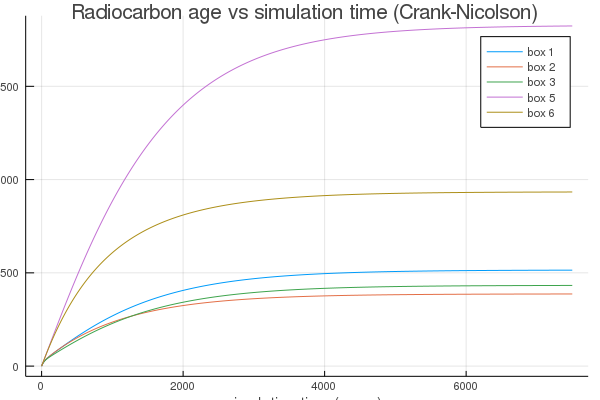

In [23]:
using Plots
C14age_hist = -log.(x_hist) * ustrip(p.τ * u"s" |> u"yr")
plt = plot(t_hist * ustrip(1u"s" |> u"yr"), C14age_hist'; label="box " .* string.(iwet))
xlabel!(plt, "simulation time (years)")
ylabel!(plt, "Radiocarbon age (years)")
title!(plt, "Radiocarbon age vs simulation time (Crank-Nicolson)")

The box model took more than 4000 years to spin up to equilibrium.
For a box model that's no big deal because it is not computationally expensive to run the model, but for a big circulation model waiting for the model to spinup is painfully long.
We therefore want a better way to find the equilibrium solution.

## Solving Directly for the Steady State

With the AIBECS, you can create the steady state problem and solve it in just 2 commands:

In [24]:
prob = SteadyStateProblem(F, ∇ₓF, x, p)
x_final = solve(prob, CTKAlg()).u

5-element Array{Float64,1}:
 0.9395557449765636
 0.9542341322419018
 0.9489433863241395
 0.8016816657976091
 0.8931162915594041

Converting radiocarbon into years gives the following values

In [25]:
C14age_final = -log.(x_final) * p.τ * u"s" .|> u"yr"
println.("box ", iwet, ": ", C14age_final);

box 1: 515.4096830423174 yr
box 2: 387.26092416145366 yr
box 3: 433.2228144719094 yr
box 5: 1827.2890596434493 yr
box 6: 934.448719655651 yr


These are exactly the limit that the Radiocarbon age reaches after about 4000 years of simulation!
So what happened there?

Well, AIBECS used a version of [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method) to solve for $\boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p}) = 0$.
Simply put, Newton's method iterates on the state via the recursion relation

$$\boldsymbol{x}_{n+1} = \boldsymbol{x}_n - \nabla_{\boldsymbol{x}}\boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p})^{-1} \boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p}).$$

Here, our radiocarbon model only requires a single iteration.
This is because the state function, $\boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p})$, is linear.

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*